### Titanic
<b>Submitted by:</b> Koh Kai Feng, Jason <br>
<b>Last edited:</b> 23/11/2019 <br>
<b>Highest Accuracy (Kaggle):</b>  81.339 % [As of 23/11/2019] <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## Importing the dataset
## Files: test.csv, train.csv 
################################

dataset1 = pd.read_csv('./dataset/train.csv')
dataset2 = pd.read_csv('./dataset/test.csv')
pid = dataset2['PassengerId']

## combing two dataset gives it a better average overall
#########################################################

td = pd.concat([dataset1,dataset2], sort=False) 

List of missing data: 


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

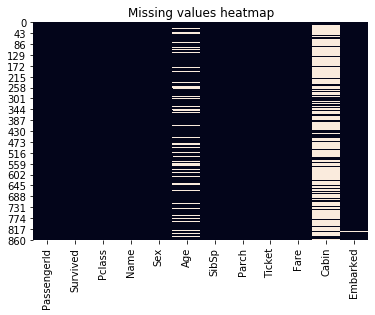

In [2]:
## Checking for missing data
##
## Note(1): There are missing data for the column "Age" and "Cabin"
###############################################################################

## Heatmap representation of missing data
##########################################
sns.heatmap(dataset1.isnull(), cbar = False).set_title("Missing values heatmap")

## Numerical Value of missing data
###################################
print("List of missing data: ")
dataset1.isnull().sum()

In [3]:
## Checking the data type of the dataset
#########################################
td.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

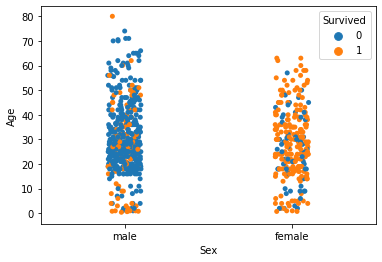

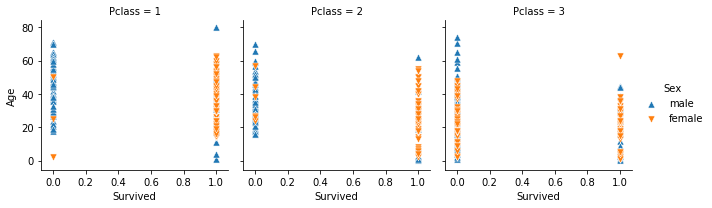

In [4]:
## Vizualizing Female vs Male survival rate based on Pclass
## Note(1): It is clear to see, that female, despite Age have a higher rate of survival when compared to
##          Males, hence later on Sex will be encoded using a Ordinal Encoder
##          
##          Female > Male in survival
#########################################################################################################
sns.stripplot(x="Sex", y="Age",hue="Survived", data=dataset1, jitter=True)

kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(dataset1, col="Pclass", hue="Sex",hue_order=["male", "female"],hue_kws=dict(marker=["^", "v"]))
g = (g.map(plt.scatter, "Survived","Age",**kws).add_legend())

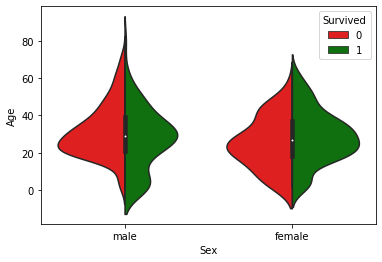

In [5]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=dataset1, split=True, palette={0: "r", 1: "g"});

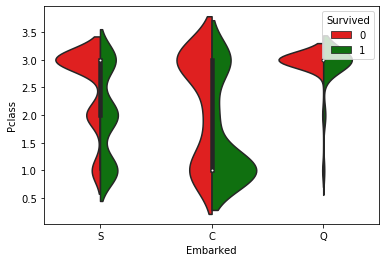

In [6]:
## Correlate survival base off Embarked location alongside Pclass
## Note(1): [C]herbourg | [Q]ueenstown | [S]outhampton
## Note(2): Interesting to see that based off emarkation point, one is able to determine the likelihood of survival
##          Interesting to note that those from Cherbourg are mostly from Pclass 1 and those from Queenstown are Pclass 3
##########################################################################################################################
sns.violinplot(x='Embarked', y='Pclass', hue='Survived', data=dataset1, split=True, palette={0: "r", 1: "g"});

In [7]:
## Extracting the Salutation from the combined dataset
## Note(1): We have seen in the first part that the Age variable was missing 177 values. 
##          This is a large number ( ~ 13% of the dataset). Simply replacing them with the mean or the median age will
##          not a accurate representation.
##
## Note(2): Using the salutation found in the names from the dataset, we can create afew categories. Basing off those
##          categories, we are then able to:
##            1) Fill in the missing age base on a more accurate range (Based of the salutation)
##            2) Used those categories as a form of feature, as certian groups might have a higher survival rate
#######################################################################################################################
td['Name'] = td.Name.apply(lambda Name: Name.split(',')[1].split('.')[0].strip())

## Replacement / Cleaning of salutation
## Note(1): Binning of rarer salutation in a group called "rare"
#################################################################

td['Name'] = td['Name'].replace(['Lady', 'the Countess', 'Don', 'Sir', 'Jonkheer'], 'Royalty')
td['Name'] = td['Name'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev'], 'Officer')
td['Name'] = td['Name'].replace('Mlle', 'Miss')
td['Name'] = td['Name'].replace('Ms', 'Miss')
td['Name'] = td['Name'].replace('Mme', 'Mrs')

## Displaying out the compressed Salutation
############################################
td['Name'].groupby(td['Name']).count()

Name
Dona         1
Master      61
Miss       264
Mr         757
Mrs        198
Officer     23
Royalty      5
Name: Name, dtype: int64

In [8]:
## Correlate survival base off salutation
##########################################
td[['Name','Survived']].groupby(['Name'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Name,Survived
4,Mrs,0.793651
2,Miss,0.702703
6,Royalty,0.600000
1,Master,0.575000
5,Officer,0.277778
3,Mr,0.156673
0,Dona,NaN


In [9]:
## Getting the medians  
#######################
grouped_train = td.groupby(['Name'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train['Age'].round()
grouped_median_train = grouped_median_train.reset_index()[['Name', 'Age']]

## Covert Pandas data into Dict: medians
## To be used later when replacing null age
############################################
medians = grouped_median_train.set_index('Name')['Age'].to_dict()

## OUTPUT
##########
medians

{'Dona': 39.0,
 'Master': 4.0,
 'Miss': 22.0,
 'Mr': 29.0,
 'Mrs': 35.0,
 'Officer': 50.0,
 'Royalty': 40.0}

In [10]:
## Fill all missing age values with "-1" value
## Note(1): Can't use "NaN" in a conditional statement. Hence, convert NaN to '-1' to be used in conditional statement
#######################################################################################################################
td['Age'].fillna(-1,inplace=True)

## fill in one missing fare value
##################################
td.Fare.fillna(td.iloc[:891].Fare.mean(), inplace=True)

## Two missing embarked values - filling them with the most frequent one in the train  set(S)
##############################################################################################
td.Embarked.fillna('S', inplace=True)

## Replacing missing age values with median of age value according to Salutations
##################################################################################
for index, row in td.iterrows():
    if row['Age'] == -1:
        td.loc[index, 'Age'] = medians[row['Name']]

In [11]:
## Combining the SibSP and Parch into one column: Family
#########################################################
td['Family'] = td.Parch + td.SibSp

In [12]:
## Correlate survival based on Family size
## Note(1): Interesting to see that family size of 3 actually have the best rate of survival
#############################################################################################
td[['Family','Survived']].groupby(['Family'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [13]:
## Ordinal Encoder
###################
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

td['Pclass'] = encoder.fit_transform(td.Pclass.values.reshape(-1, 1))
td['Family'] = encoder.fit_transform(td.Family.values.reshape(-1, 1))
td['Sex'] = encoder.fit_transform(td.Sex.values.reshape(-1, 1))

## One hot encoding 
####################
Embarked_encode = pd.get_dummies(td['Embarked'], prefix='Emb')
td = pd.concat([td,Embarked_encode], axis=1)

Name_encode = pd.get_dummies(td['Name'], prefix='Title')
td = pd.concat([td,Name_encode], axis=1)

In [14]:
## Splitting of training / testing data
########################################
td['Survived'].fillna(-1,inplace=True)

trainingds = td['Survived'] != -1
testingds = td['Survived'] == -1

training_data = td[trainingds]
testing_data = td[testingds]

## Dropping of unused columns before training model
####################################################
testing_data = testing_data.drop(['Survived','Name','Parch','SibSp','PassengerId','Cabin','Embarked','Fare','Ticket'], axis=1)

survived = training_data['Survived'].dropna()
training_data = training_data.drop(['Survived','Name','Parch','SibSp','PassengerId','Cabin','Embarked','Fare','Ticket'], axis=1)

In [15]:
## split train dataset into training and testing sets
######################################################
from sklearn.model_selection import train_test_split
from sklearn import model_selection

X, y = training_data, survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Note(1) Function "grad_boost" helpes to determin the best perimeter to be used for prediction 
#################################################################################################

random_state = 0

def grad_boost(X, Y, X_test):

    parameters = {'max_depth' : [2, 4, 10, 15], 
                  'n_estimators' : [10, 50, 100], 
                  'min_samples_split' : [5, 10, 15],
                 }
    kfold = model_selection.KFold(n_splits=3, random_state=random_state, shuffle = True)
    model_GBC = GradientBoostingClassifier(random_state = 5)
    search_GBC = GridSearchCV(model_GBC, parameters, n_jobs = -1, cv = kfold, scoring = 'accuracy',verbose=1)
    search_GBC.fit(X, Y)
    predicted= search_GBC.predict(X_test)
    
    print("Best parameters are:", search_GBC.best_params_)
    print("Best accuracy achieved:",search_GBC.cv_results_['mean_test_score'].mean())
    
    return search_GBC.best_params_, model_GBC, search_GBC, predicted


In [17]:
## Calling the function "grad_boost" to test for best perimeter
################################################################
param_GBC_onehot, model_GBC_onehot, search_GBC_onehot, predicted_cv_GBC_onehot = grad_boost(X_train, y_train, testing_data)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s


Best parameters are: {'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 10}
Best accuracy achieved: 0.7953729712858926


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    7.4s finished


In [18]:
## Function 'fit_pred_GBC' is used for prediction
## Note(1): Take in X_train and y_train alongside the actual testing_data
## Note(2): Returns the predicted outcome and the trained model
##########################################################################
def fit_pred_GBC(X, Y, X_test):

    model_GBC = GradientBoostingClassifier(max_depth = 4, min_samples_split = 10, n_estimators = 10, random_state = 5, max_features= 'auto')

    model_GBC.fit(X, Y)
    predicted= model_GBC.predict(X_test)
    
    return predicted, model_GBC

In [19]:
## Evaluation of the model using only training data
####################################################
from sklearn.metrics import confusion_matrix, accuracy_score

predicted_GBC_onehot, model_GBC_onehot = fit_pred_GBC(X_train, y_train, X_test)

cm = confusion_matrix(y_test, predicted_GBC_onehot)
tn, fp, fn, tp = confusion_matrix(y_test, predicted_GBC_onehot).ravel()

print(cm)
print("True Negative: ", tn)
print("True Positive: ", tp)
print("False Positive: ", fp)
print("False Negative: ", fn)
print("Accuracy: ", accuracy_score(y_test, predicted_GBC_onehot))

[[97  7]
 [28 47]]
True Negative:  97
True Positive:  47
False Positive:  7
False Negative:  28
Accuracy:  0.8044692737430168


In [20]:
## Saving Model
################
from sklearn.externals import joblib
#joblib.dump(model_GBC_onehot, 'Titanic_trained_model.pkl')
#clf3 = joblib.load('Titanic_trained_model.pkl')

D:\Programs\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


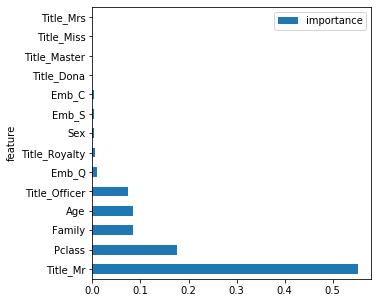

In [21]:
## Post-Prediction analysis
## Note(1): Based of the trained model, determins the importantance of certains features
##########################################################################################
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model_GBC_onehot.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

## OUTPUT
## Note(1): It is clear to see that certain features plays a more important role in determining survival rates
## Note(2): This was used as a consideration on which column to drop and which to include for prediction
## Note(3): As outputed, these are the columns that i've decided to stick with
###############################################################################################################
importances.plot(kind='barh', figsize=(5, 5))

In [22]:
## Predict lables
##################
predicted_GBC_onehot, model_GBC_onehot = fit_pred_GBC(X_train, y_train , testing_data)

## Output prediction into CSV
##############################
kaggle = pd.DataFrame({'PassengerId': pid, 'Survived': predicted_GBC_onehot.astype(int)})
kaggle.to_csv('GBCresult.csv', index=False)

# Conclusions

<h3>Q1 - How is your prediction task defined? And what is the meaning of the output variable?</h3>
<p>
    <b>Answer :</b>
    <br>
    My prediction task is to predict whether an individual survives the Titanic Disaster based on a given set of perimeters
    <br>
    The output variable produced in my predictions is [1, 0]. It determins whether a particualr individual survived the Titanic Disaster.
</p>
_______________________________________________________________________________________________________________

<h3>Q2 - How do you represent your data as features?</h3>
<p>
    <b>Answer :</b>
    <br>
    I made used of the <u>OrdinalEncoder</u> from <u>sklearn</u> and <u>pandas</u>'s <u>one-hot enconding</u> to encode my features
    <br>
    The following is the features i've used to train my model
    <ol>
        <li>Pclass</li>
        <li>Sex</li>
        <li>Age</li>
        <li>Family</li>
        <li>Emb_C</li>
        <li>Emb_Q</li>
        <li>Emb_S	</li>
        <li>Title_Dona</li>
        <li>Title_Master</li>
        <li>Title_Miss</li>
        <li>Title_Mr</li>
        <li>Title_Mrs</li>
        <li>Title_Officer</li>
        <li>Title_Royalty</li>
    </ol>
    <br>
    All features except <b>Age</b> and <b> Family </b> has either been encoded via Ordinal or one-hot encoding accordingly.
</p>
_______________________________________________________________________________________________________________

<h3>Q3 - Did you process the features in any way?</h3>
<p>
    <b>Answer :</b>
    <br>
    Yes. Initially there were 177 missing Age, 687 missing Cabin and 2 missing Embarked in the given training dataset. 
    <br><br>
    Seeing how cabin has so much missing data, I decided to leave out the column entirely.
    <br><br>
    The column 'Age' have quite a number of missing data as well, but based off the statistics i've gathered 'Age' plays a crucial role in determining survival of an individual. As such, I decided to replace missing age using the <u>median</u> of the other passengers. I group the passengers together based off the given salutations: 
    <table>
        <tr>
            <th>Title</th>
            <th>No. of</th>
            <th>Median Age</th>
        </tr>
        <tr>
            <td>Dona</td>
            <td>1</td>
            <td>39</td>
        </tr>
        <tr>
            <td>Master</td>
            <td>61</td>
            <td>4</td>
        </tr>
        <tr>
            <td>Miss</td>
            <td>264</td>
            <td>22</td>
        </tr>
        <tr>
            <td>Mr</td>
            <td>757</td>
            <td>29</td>
        </tr>
        <tr>
            <td>Mrs</td>
            <td>198</td>
            <td>35</td>
        </tr>
        <tr>
            <td>Officer</td>
            <td>23</td>
            <td>50</td>
        </tr>
        <tr>
            <td>Royalty</td>
            <td>5</td>
            <td>40</td>
        </tr>
    </table>
    <br>
    With the passangers groups together via salutations, the median Age used to replace those without an Age would be more
    appropriate.
    <br>
    Note: Dona is an odd one out. So I decided to just leave it as it is.
    <br>
    <br>
    I've also engineered <b>two features</b> that was used in my prediction model.
    <ol>
        <li>Family</li>
        <li>Title (As seen from the table above)</li>
    </ol>
    <br>
    Family was derived from the combination of <u>Sibsp</u> and <u>Parch.</u>
    <br><br>
    The extracted salutations first used to fill the missing Age are also used to train the model
</p>
_______________________________________________________________________________________________________________

<h3>Did you bring in any additional sources of data?</h3>
<p>
    <b>Answer: </b>
    No
</p>
_______________________________________________________________________________________________________________

<h3>How did you select which learning algorithms to use?</h3>
<p>
    <b>Answer: </b>
    <br>
    I've chosen <u>Gradient boosting</u> as the algorithm generally gives better results when compared to algorithms such as Random Forest when solving classification problems. Although it is more prone to overfitting and more resource intensieve overall. When used to predict the survivers of the Titanic Disaster the small dataset proves to not be a problem in regards to the resourced used (computing time is minimal). As for overfitting, after applying the setting given by hypertuning, accuracy have not been a problem as well.
</p>
_______________________________________________________________________________________________________________

<h3>Did you try to tune the hyperparameters of the learning algorithm, and in that case how?</h3>
<p>
    <b>Answer:</b>
    <br>
    Yes. I made used of <u>GridSearchCV</u> from <u>sklearn</u> to help fine tune the hyperparameters of my learning algorithm. 
</p>
_______________________________________________________________________________________________________________

<h3>How do you evaluate the quality of your system?</h3>
<p>
    <b>Answer: </b>
    <br>
    Ultimately, I made used of Kaggle to determine the quality of my system. <br>
    However, before submitting to Kaggle, there are two ways that I used to give me a rough estimate on my system's accuracy rate.
    <ol>
        <li>Accuracy results from Grid Search</li>
        <li>confusion Matrix based of Training Data set</li>
    </ol>
    
</p>
_______________________________________________________________________________________________________________

<h3>How well does your system compare to a stupid baseline?</h3>
<p>
    <b>Answer: </b>
    <br>
    Testing both the "stupid baseline" and my system on Kaggle: <br><br>
    The "stupid baseline" provided produced an accuracy score of <b>62.679%</b><br>
    My system produced an accuracy score of <b>81.339% (As of 23/11/2019)</b><br>
    An improvement of <b>18.66%</b> overall !
</p>
_______________________________________________________________________________________________________________

<h3>Can you say anything about the errors that the system makes?</h3>
<p>
    <b>Answer: </b>
    <br>
    Based of the training data's confusion matrix i've obtain the following data:<br><br>
    True Negative:  97 <br>
    True Positive:  47 <br>
    False Positive:  7 <br>
    False Negative:  28 <br>
    Accuracy:  0.8044692737430168 <br>
    <br>
    From the above data, it is clear that my model have a higher tendency in giving producing False Negative.
</p>
_______________________________________________________________________________________________________________

<h3>Is it possible to say something about which features the model considers important? </h3>
<p>
    <b>Answer: </b>
    <br>
    It would be easier to answer with a graph, as such see the graph below.
    <br>
    The importance of each feature was derived from just the training dataset alone.
</p>
_______________________________________________________________________________________________________________

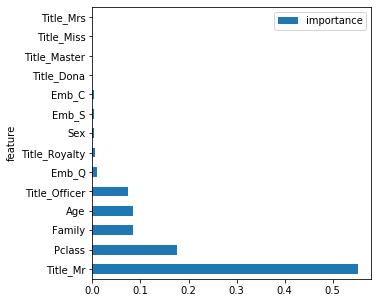

In [23]:
importances.plot(kind='barh', figsize=(5, 5))